# Esercitazione 4: Text Segmentation

In questa esercitazione vedremo come implementare un algoritmo per la segmentazione di un documento testuale in *unità informative coerenti*.

Tra i molteplici approcci proposti in letteratura, si è scelto di implementare un algoritmo basato sul *Text Tiling* proposto da  [M. A. Hearst](https://www.aclweb.org/anthology/J97-1003.pdf).

In [1]:
from pathlib import Path
import nltk
import numpy as np

import src.data_manager as dm
import src.text_segmentation as segm
import src.viz as viz

import matplotlib.pyplot as plt

plt.style.use('seaborn')

[nltk_data] Downloading package punkt to /home/prf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/prf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dati 
I 5 documenti scelti per l'esercitazione, sono stati campionati in **modo casuale** da un sottoinsieme di 100 documenti presenti nel dataset [WIKI-727K](https://arxiv.org/pdf/1803.09337.pdf). Il dataset è composto da una collezione di $727,746$ documenti di Wikipedia in lingua Inglese. Ogni documento è diviso in "sezioni tematiche", la cui fine, è contassegnata dal pattern simbolico .


La classe `data_manager.Document` rappresenta il principale oggetto di lavoro. I metodi implementati, permettono di effettuare il parsing del documento, la divisione in *chunks* e l'estrazione dei separatori delle sezioni.

I **chunks** sono le unità informative di base processate dall'algoritmo. La natura del chunk dipende dal **livello di granularità** scelto (parole, frasi, paragrafi, ecc. ). Per rendere l'algoritmo agnostico e trasparente dalla granularità scelta, durante la creazione dell'istanza Document, viene dato input una funzione *tokenizer* che implementa la logica di tokenizzazione. In questa esercitazione si è scelto di lavorare a livello di frasi, dunque, un chunk rappresenta l'unità informativa della frase.

Inoltre le annotazioni che demarcano la fine di una sezione, che qui chiameremo rispettivamente breakpoints e blocchi, sono di fondamentale importanza per la fase di valutazione. Come riportato da [M. A. Hearst](https://www.aclweb.org/anthology/J97-1003.pdf) non possiamo assumere che la **separazione del testo in paragrafi** sia informativa per il task in questione e dunque che ogni paragrafo rappresenti **un'unità informativa coerente**. A differenze di quanto "ci viene insegnato a scuola", spesso le persone tendono a dividere il contenuto in paragrafi sulla base di un criterio "estetico-strutturale" piuttosto che coerente dal punto di vista informativo.




In [2]:
doc = dm.Document(Path('data/test_doc.txt'), nltk.sent_tokenize, search_title=True)

title = doc.title.split(".")[0] # get first part of the title

print(f'Document title: "{title} ..."\n')

N = 10
chunks = '\n'.join(doc.get_chunks()[0:N])
print(f"Document's first {N} chunks:\n{chunks}\n")
print(f"Document's blocks breakpoints:{doc.get_breakpoints()}")

Document title: "Associative Memory, habits are conditioned ..."

Document's first 10 chunks:
I used to love burgers from McDonald's.
I was skinny six-year-old, with flat cheeks and wide eyes.
You wouldn't have expected me to fit two bites down my throat.
But somehow, I had the capacity to devour two whole burgers of fast food junk.
My mother was always aghast watching me down a meal for two adults — I was barely out of kindergarten, after all.
Then, one day, when I was in the 3rd grade, my family was travelling back home from a hill station we’d been vacationing at.
I’d been sitting quietly in the back of the car for over five hours, as we braved the torrential rains flooding the mountain range west of our city.
Stuck in the deluge with endless Indian traffic and nowhere to go, we stopped at my favourite place— McDonald’s.
As always, I ordered my usual two burgers.
We received our order while still in the car, and continued the drive towards home.

Document's blocks breakpoints:[(14, 

### Glove embedding

Per valutare la coerenza tra due blocchi è stato utilizzata la *cosine similarity*; di conseguenza bisogna utilizzare una rappresentazione vettoriale. 

Si è scelto di utilizzare la risorsa *Glove* come modello di rappresentazione vettoriale. Glove è un **word embedding** ottenuto dal training non supervisionato sulla **matrice di co-occorrenza word-word**. Ogni entry della matrice rappresenta quanto frequentemente un parola co-occorre con un'altra nel corpus considerato.

L'idea alla base di Glove nasce da una semplice osservazione: la probabilità di co-occorrenza, potenzialmente codifica una "qualche forma di significato" tra le parole coinvolte:

![](https://nlp.stanford.edu/projects/glove/images/table.png)


L'obiettivo di Glove è creare uno spazio in cui il prodotto scalare tra 2 vettori è uguale al logaritmo delle probabilità delle co-occorenze delle due parole associate.

La classe `data_manager.Glove` rappresenta un semplice wrapper per caricare in memoria ed accedere ai vettori dell'embdedding. 

I creatori di Glove hanno rilasciato degli embedding pretrained di differenti dimensioni, nell'esercitazione verrà usata la versione `glove.6B.300d`, uno spazio vettoriale a 300 dimensioni ottenuto dopo una fase di training sul corpus *English Gigaword Fifth Edition* da 6 miliardi di token e un dump di *Wikipedia* del 2014. 

Vediamo dei semplici esempi





In [3]:
glove_path = Path("data/glove.6B.300d.txt")
glove = dm.Glove(glove_path)

In [4]:
word_pairs = [("memory","brain"),("memory","vision"),
              ("vision","brain"), ("brain","lemon")]

for w1, w2 in word_pairs:
    sim = segm.cosine_similarity(glove[w1], glove[w2])
    print(f"{w1}-{w2}: {sim}")


memory-brain: 0.4397561194147497
memory-vision: 0.3179046520575246
vision-brain: 0.30173050373193067
brain-lemon: 0.018542670368901337


## Text segmentation

Il task prevede di segmentare il testo in blocchi coesi dal punto di vista informativo. Solitamente si cerca di suddividere il testo in modo tale che ogni blocco rappresenti un **sub topic** rispetto al contenuto complessivo.

L'approccio utilizzato si basa sull'algoritmo di *Text Tiling* proposto da M.A. Hasting, il cui obiettivo è partizionare testi espositivi in **unità multi-paragrafo coerenti** che riflettono la struttura a sub-topic del testo. Alla base dell'algoritmo c'è una semplice assunzione: quando il sub-topic di un discorso cambia, una porzione significativa del **vocabolario** cambia con esso.

L'algoritmo qui proposto, pur mantenendo una certa coerenza con il Text Tiling, si discosta dall'misurare la coerenza attraverso il cambiamento di vocabolario nei sub-topic e piuttosto si concentra sulla similarità lessico-semantica tra di essi.

L'approccio utilizzato si basa sui seguenti steps:

1. Suddividere il testo in un prefissato numero blocchi $B_1,\ldots,B_k$ di **lunghezza omogenea**. Ogni blocco contiene (approssimativamente) lo stesso numero di chunks:
$$|B_1| \approx |B_2|, \ldots,|B_{k-1}| \approx |B_k|$$

2. Calcolare la **similarità tra blocchi adiacenti** $B_i, B_{i+1} \quad i=1,\ldots, k-1$. La similarità viene calcolata come **similarità media** tra tutte le possibili **coppie di chunks**:

    $$(c_n^{i}, c_m^{i+1})$$

    dove i chunks $c_n,c_m$ della coppia appartengono rispettivamente al blocco $B_i$ e il blocco adiacente $B_{i+1}$. Da notare che $n=1,\ldots, |B_i|$ e $m=1,\ldots,|B_{i+1}|$

3. I breakpoints vengono individuati come **minimi locali** della funzione di similarità al variare dei blocchi.

La logica dell'approccio appena esposto è implementata nei metodi della classe `text_segmentation.TextSegmenter`. La funzione `viz.block_similarity_plot` permette di riprodurre lo stesso plot utilizzato nel paper originale:

![](https://d3i71xaburhd42.cloudfront.net/d7b3c8019d8d1dfe6bc1f627c236cd5cab40134c/4-Figure3-1.png)

Di seguito riportiamo l'esecuzione dell'algoritmo sul documento di esempio:

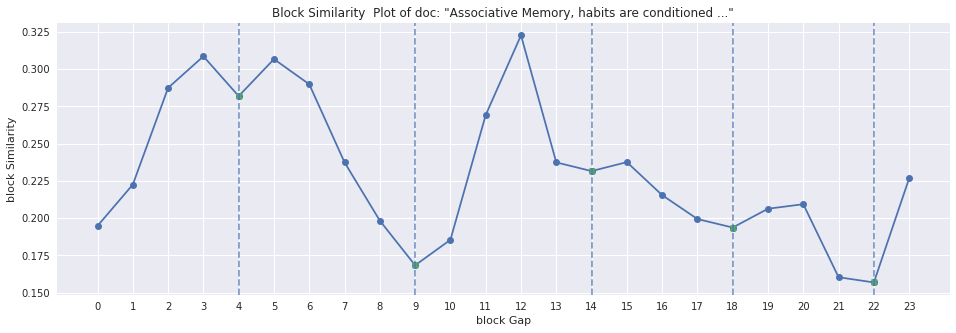

In [5]:
segmenter = segm.TextSegmenter(segm.preprocessor, glove, segm.cosine_similarity)
INITIAL_BLOCKS = 25 # is chosen carefully for demonstration purpose
minima, similarities, blocks = segmenter.segment(doc, initial_blocks=INITIAL_BLOCKS)


fig, ax = plt.subplots(1,1,figsize=(16,5))
viz.block_similarity_plot(ax, doc, minima, similarities)

Le "valli" (minimi locali) individuate dal metodo `TextSegmenter.segment()` corrispondono ai punti in cui la similarità tra due **blocchi adiacenti** è minima, dunque non è una misura associata ad un singolo blocco piuttosto ad una coppia.

Dato che i breakpoint originali sono espressi in termini di chunks piuttosto che blocchi, si necessità trasformare le valli individuate dall'algoritmo (la cui posizione è espressa in termini di blocchi) in breakpoints (la cui posizione è espressa in termini di chunks). La logica appena esposta è implementata nella funzione  `viz.valleys_to_breakpoints`

In [7]:
valleys, sims, blocks = segmenter.segment(doc, initial_blocks=25) # 25 here is chosen carefully for demonstration purpose
breakpoints, system_chunks = viz.valleys_to_breakpoints(valleys, blocks)

# get only chunk indeces before the breakpoints
true_breakpoints = np.array([breakpoint[0] for breakpoint in doc.get_breakpoints()])
system_breakpoints = np.array([breakpoint[0] for breakpoint in breakpoints])

print(f"Gold Truth breakpoints : {true_breakpoints}\nSystem's breakpoints: {system_breakpoints}")

Gold Truth breakpoints : [14 29 36 60 75]
System's breakpoints: [15 36 55 68 81]
/home/prf/miniconda3/envs/TLN/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Valutazione

Da notare come ci sono essenzialmente due dinamiche che contribuiscono all'errore commesso dall'algoritmo rispetto ai veri breakpoints:

* numero di blocchi (sezioni) differenti
* scostamento dell'inizio e fine (span) dei blocchi 

La funzione `viz.block_span_plot` permette di visualizzare graficamente quanto appena descritto: 

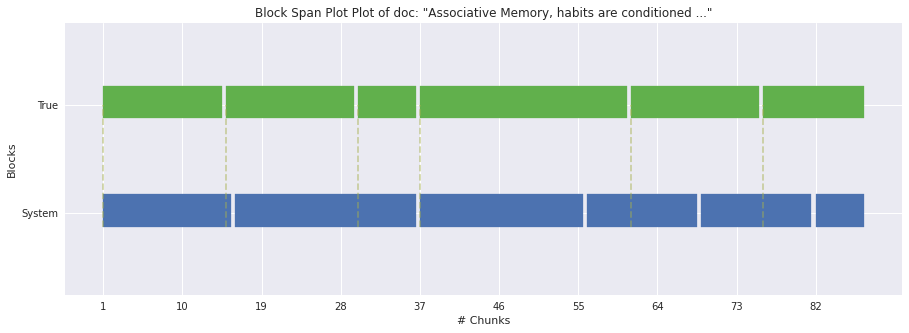

In [107]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
viz.block_span_plot(ax, doc, true_breakpoints, system_breakpoints)

Nel caso il numero di blocchi individuati siano gli stessi di quelli originali possiamo **valutare l'errore commesso** calcolando lo scostamento medio come segue:

In [9]:
if len(true_breakpoints) == len(system_breakpoints):
    diff = np.abs(true_breakpoints-system_breakpoints)
    print(f"Avg offset error {diff.mean()}+-{diff.std():.2f}, with min {diff.min()} and max {diff.max()}")

Avg offset error 8.2+-5.91, with min 1 and max 19


### Esecuzione Batch 
Di seguito effettuiamo la segmentazione su 8 documenti campionati in modo uniforme da un subset del dataset *WIKI-727K*

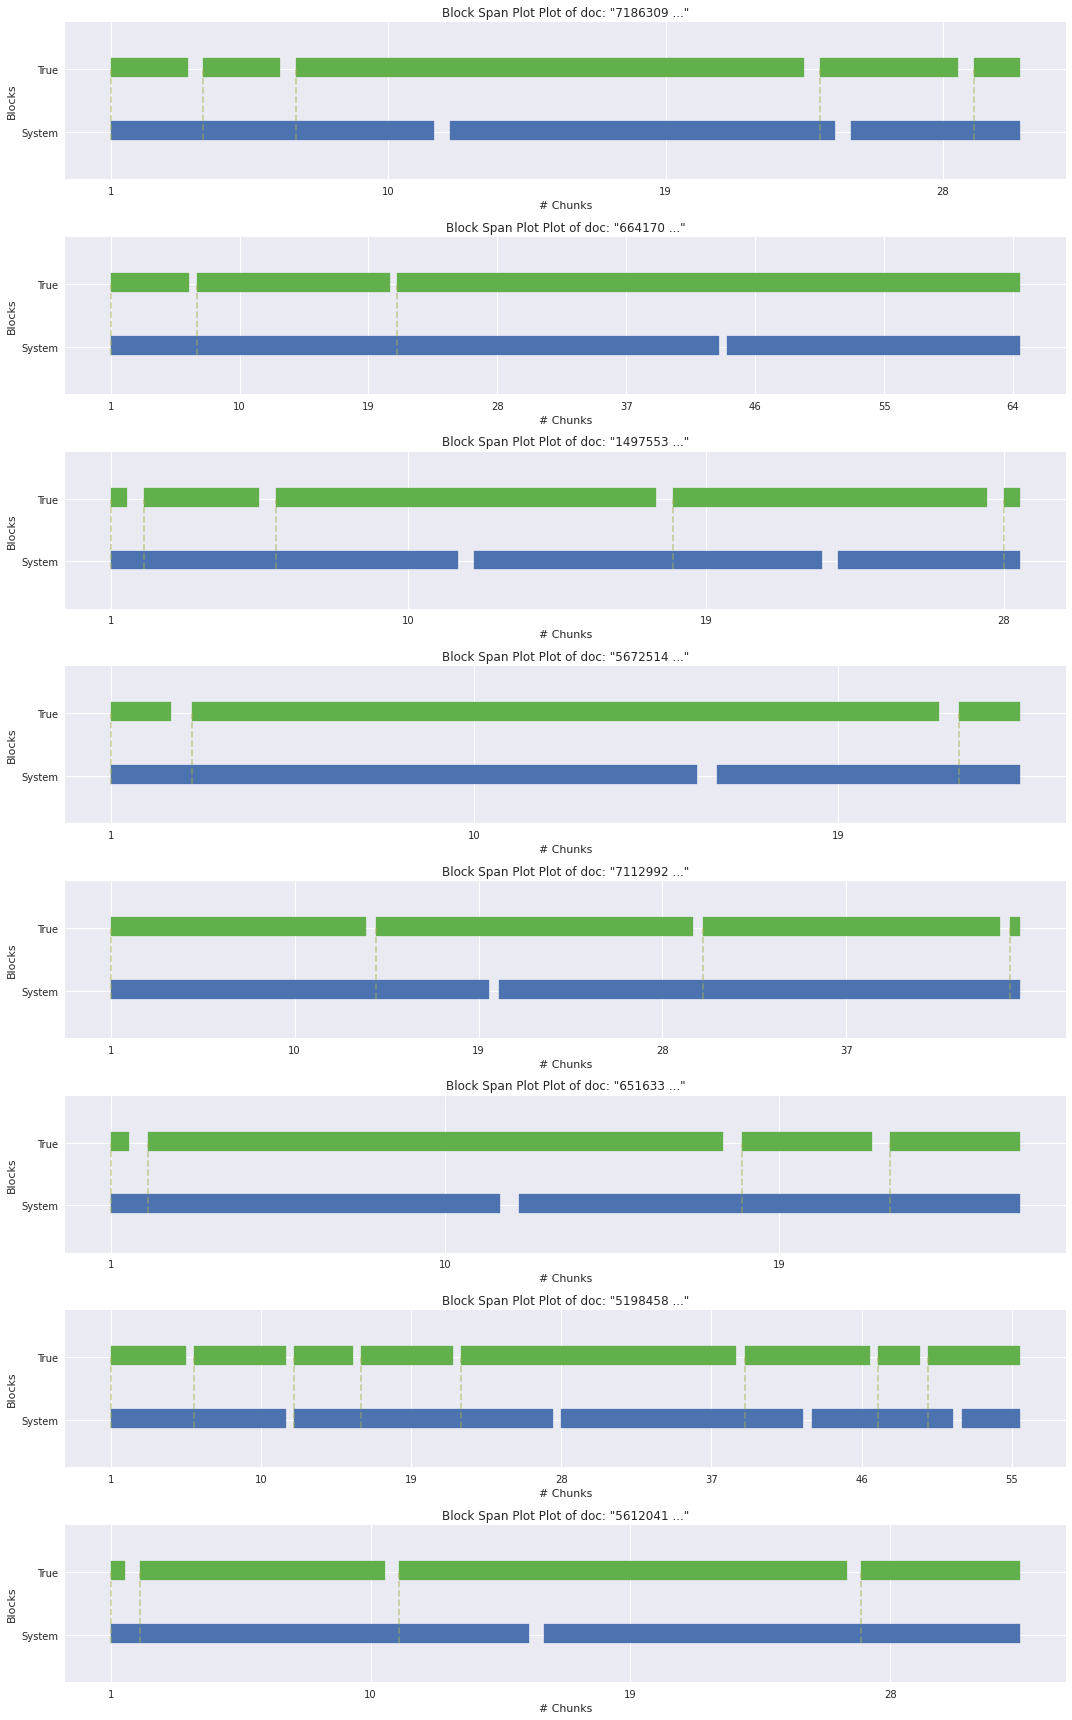

In [10]:
import random
random.seed(10)

N_DOCS = 8

doc_paths = list(filter(lambda x: x.is_file(), Path("data/WIKI-727K-subset").rglob("*")))
doc_paths = random.sample(doc_paths, N_DOCS)

docs = [dm.Document(doc_path, nltk.sent_tokenize) for doc_path in doc_paths]
segmenter = segm.TextSegmenter(segm.preprocessor, glove, segm.cosine_similarity)

fig, axes = plt.subplots(nrows=N_DOCS, figsize=(15,3*N_DOCS))

for pa, doc, ax in zip(doc_paths,docs,axes):
    INITIAL_BLOCKS = len(doc.get_breakpoints()) * 3 # this is an unfair trick!!!
    minima, similarities, blocks = segmenter.segment(doc, initial_blocks=INITIAL_BLOCKS, smooth=True, window_size=3)
    breakpoints, system_chunks = viz.valleys_to_breakpoints(valleys, blocks)
    
    true_breakpoints = np.array([breakpoint[0] for breakpoint in doc.get_breakpoints()])
    system_breakpoints = np.array([breakpoint[0] for breakpoint in breakpoints])
    
    viz.block_span_plot(ax, doc, true_breakpoints, system_breakpoints)

fig.tight_layout()


Da un'analisi qualitativa dei plot, emerge come fenomeno principale quello dell'**under-segmentation** ovvero lo span dei blocchi (sezioni) individuati dal sistema è molto più grande rispetto a quello dell'originale, di conseguenza un blocco del sistema spesso si estende per 2 o più blocchi originali.

Questo risultato non soprende molto in quanto l'algoritmo è altamente dipendente dal parametro INITIAL_BLOCKS.

L'approccio può essere notevolmente migliorato! Di seguito presentiamo alcune possibili estensioni:

* Rendere il numero di blocchi iniziali adattivo così come lo smoothing applicato, ad es. con valori di smoothing differenti da blocco a blocco.
* Incrementare e decrementare il numbero di breakpoints --> meccanismi di merging e splitting ricorsivo dei blocchi.
* sperimentare il comportamento dell' algoritmo al variare dei parametri (# di blocchi iniziali, parametri algoritmo di minimi locali, finestra di smoothing, ecc..)